## Predict emotions using text inputs

In [ ]:
from google.colab import files
files.upload()

In [2]:
# create directory and move kaggle.json to directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# download dataset
!kaggle datasets download -d praveengovi/emotions-dataset-for-nlp

  0% 0.00/721k [00:00<?, ?B/s]
100% 721k/721k [00:00<00:00, 47.6MB/s]


In [4]:
# View downloaded files
!ls -d $PWD/*

 /content/a_weights.best.hdf5		 /content/sample_data
 /content/emotions-dataset-for-nlp.zip	 /content/test.txt
'/content/kaggle (1).json'		 /content/train.txt
 /content/kaggle.json			 /content/val.txt


In [ ]:
# Unzip files
!unzip \*.zip && rm *.zip

In [6]:
# View unzipped  files
!ls -d $PWD/*

 /content/a_weights.best.hdf5		 /content/sample_data
 /content/emotions-dataset-for-nlp.zip	 /content/test.txt
'/content/kaggle (1).json'		 /content/train.txt
 /content/kaggle.json			 /content/val.txt


In [32]:
# import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [33]:
# read data into dataframe
train_data = pd.read_csv('/content/train.txt', sep=';', header=None, names=['input', 'sentiment'])
val_data = pd.read_csv('/content/val.txt', sep=';', header=None, names=['input', 'sentiment'])
test_data = pd.read_csv('/content/train.txt', sep=';', header=None, names=['input', 'sentiment'])

In [34]:
print('The shape of train data: {}'.format(train_data.shape))
print('The shape of val data: {}'.format(val_data.shape))
print('The shape of test data: {}'.format(test_data.shape))

The shape of train data: (16000, 2)
The shape of val data: (2000, 2)
The shape of test data: (16000, 2)


In [35]:
# display first 4 rows  of train data
train_data.head(4)

,input,sentiment
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love


In [36]:
# check for null values in dataframes
for data in [train_data, val_data, test_data]:
  print(data.isna().sum(), '\n')

input        0
sentiment    0
dtype: int64 

input        0
sentiment    0
dtype: int64 

input        0
sentiment    0
dtype: int64 



In [37]:
# display unique labels
train_data['sentiment'].unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

Text(0.5, 1.0, 'Count of Sentiments')

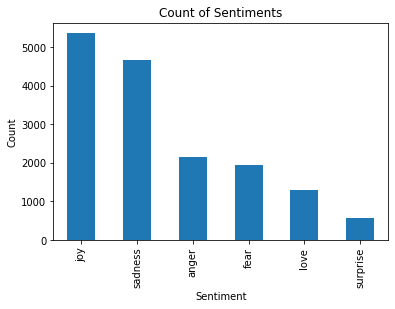

In [38]:
# visualize sentiment distribution 
train_data['sentiment'].value_counts().plot(kind='bar')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Count of Sentiments')

In [39]:
train_data.head(3)

,input,sentiment
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger


In [40]:
# seperate features and labels
train_features = train_data['input']
train_labels = train_data['sentiment']

val_features = val_data['input']
val_labels = val_data['sentiment']

test_features = test_data['input']
test_labels = test_data['sentiment']

In [41]:
# import LabelEncoder
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

In [42]:
#one hot encode labels
encoder = LabelEncoder()
encoder.fit(train_labels)

train_labels = to_categorical(encoder.transform(train_labels))
val_labels =   to_categorical(encoder.transform(val_labels))
test_labels =  to_categorical(encoder.transform(test_labels))

for label in [train_labels, val_labels, test_labels]:
  print(label[:3], '\n')

[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]] 

[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]] 

[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]] 



In [43]:
classes =encoder.classes_
classes

array(['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'],
      dtype=object)

In [44]:
# import counter
from collections import Counter

In [45]:
# get count of unique words in input
def get_num_of_words(data, text_column= 'input'):
  results = Counter()
  data[text_column].str.lower().str.split().apply(results.update)
  return len(results)

In [46]:
num_words = get_num_of_words(train_data)
num_words

15212

In [47]:
# get maximum length of text
def get_max_len(data, text_column='input'):
   max_len = data[text_column].map(len).max()
   return max_len

In [48]:
max_len = get_max_len(train_data)
max_len

300

In [49]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [50]:
# tokenize data
def tokenize(data, fit_data=train_features, num_words=15000, max_len=100):
  tokenizer = Tokenizer(num_words=num_words, oov_token='UNK')
  tokenizer.fit_on_texts(fit_data)
  sequences = tokenizer.texts_to_sequences(data)
  data = pad_sequences(sequences, max_len, padding='post', value =0)
  return data

In [51]:
# convert the text inputs to vectors
x_train = tokenize(train_features)
x_val = tokenize(val_features)
x_test = tokenize(test_features)

In [52]:
# import libraries for building model
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [53]:
# define model
def build_model():
  model = Sequential()
  model.add(Embedding(15000, 32))
  model.add(Conv1D(32, 5, activation='relu'))
  model.add(MaxPooling1D())

  model.add(Conv1D(64, 5, activation='relu'))
  model.add(GlobalMaxPooling1D())

  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(6, activation='softmax'))

  model.compile(loss= 'categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])

  return  model

In [54]:
# build model
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          480000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 64)          10304     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)               

In [55]:
# learning rate reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5, verbose = 1, factor= 0.2, min_lr = 1e-7)

# checkpoint
filepath=('a_weights.best.hdf5')
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [56]:
history = model.fit(x_train, train_labels, epochs= 40, validation_data=(x_val, val_labels),
                    batch_size = 16, callbacks = [checkpoint])

Epoch 1/40
1000/1000 [==============================] - 8s 8ms/step - loss: 1.5427 - acc: 0.3495 - val_loss: 0.7403 - val_acc: 0.7440

Epoch 00001: val_acc improved from -inf to 0.74400, saving model to a_weights.best.hdf5
Epoch 2/40
1000/1000 [==============================] - 8s 8ms/step - loss: 0.5825 - acc: 0.7915 - val_loss: 0.3385 - val_acc: 0.8910

Epoch 00002: val_acc improved from 0.74400 to 0.89100, saving model to a_weights.best.hdf5
Epoch 3/40
1000/1000 [==============================] - 7s 7ms/step - loss: 0.2754 - acc: 0.9089 - val_loss: 0.2602 - val_acc: 0.9125

Epoch 00003: val_acc improved from 0.89100 to 0.91250, saving model to a_weights.best.hdf5
Epoch 4/40
1000/1000 [==============================] - 7s 7ms/step - loss: 0.2057 - acc: 0.9312 - val_loss: 0.2708 - val_acc: 0.9095

Epoch 00004: val_acc did not improve from 0.91250
Epoch 5/40
1000/1000 [==============================] - 7s 7ms/step - loss: 0.1717 - acc: 0.9403 - val_loss: 0.2558 - val_acc: 0.9180

Epoch

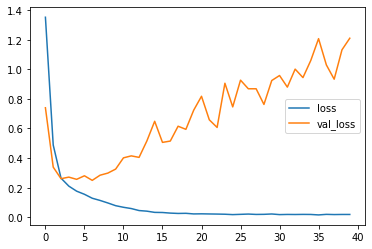

In [57]:
# visualize model performance
history_df =pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

In [58]:
#load best weights
model.load_weights('a_weights.best.hdf5')

In [59]:
from sklearn.metrics import accuracy_score

In [60]:
# evaluate model on validation date
model.evaluate(x_val, val_labels)

63/63 [==============================] - 0s 4ms/step - loss: 0.2981 - acc: 0.9225


[0.29810988903045654, 0.9225000143051147]

In [61]:
# evaluate model on validation data
model.evaluate(x_val, val_labels)

63/63 [==============================] - 0s 4ms/step - loss: 0.2981 - acc: 0.9225


[0.29810988903045654, 0.9225000143051147]

In [62]:
# evaluate model on test data
model.evaluate(x_test, test_labels)

500/500 [==============================] - 2s 4ms/step - loss: 0.0646 - acc: 0.9772


[0.06456976383924484, 0.9772499799728394]

In [63]:
# get test data predictions
y_pred = model.predict_classes(x_test)
y_pred[:5]

array([4, 4, 0, 3, 0])

In [64]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

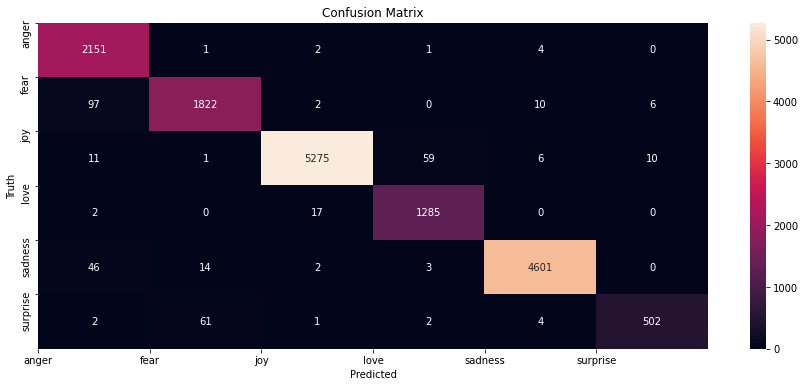

In [65]:
# visualize confusion matrix
plt.figure(figsize=(15,6))
cm = confusion_matrix(np.argmax(test_labels, axis=1), y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title ('Confusion Matrix')

labels = classes
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=0)
plt.yticks(tick_marks, labels)

plt.show()

In [66]:
# import classification report
from sklearn.metrics import classification_report

In [67]:
# display classification report
print(classification_report(np.argmax(test_labels, axis=1), y_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      2159
           1       0.96      0.94      0.95      1937
           2       1.00      0.98      0.99      5362
           3       0.95      0.99      0.97      1304
           4       0.99      0.99      0.99      4666
           5       0.97      0.88      0.92       572

    accuracy                           0.98     16000
   macro avg       0.97      0.96      0.96     16000
weighted avg       0.98      0.98      0.98     16000



In [68]:
# make predictions and class
def make_predictions(sentence):
  sentence_list = []
  sentence_list.append(sentence)
  data = tokenize(sentence_list)
  prediction = int(model.predict_classes(data))
  emotion = classes[prediction]
  print('Predicted emotion is : {}'.format(emotion))

In [69]:
# prompt users and make predictions
make_predictions(str(input('Enter a sentence here: ')))

Enter a sentence here: I dont deserve to have all these problems
Predicted emotion is : anger


In [78]:
# prompt users and make predictions
make_predictions(str(input('Enter a sentence here: ')))

Enter a sentence here: i am not sure i would pass this test
Predicted emotion is : joy
